In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import legume 
legume.set_backend('autograd')
import legume.backend as bd
import numpy as np
import autograd.numpy as npa
from autograd import grad
import time
import matplotlib.pyplot as plt
import optomization

In [ ]:
phc = optomization.W1(vars=vars,Ny=7)
gme = legume.GuidedModeExp(phc,2.01)
gme.run(d)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 145 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 0.013    │ │--------------------│    1% │
│ Inverse matrix of Fourier-space permittivity               │ 0.190    │ │████----------------│   22% │
│ Matrix diagionalization using the 'eigh' solver            │ 0.638    │ │██████████████------│   74% │
│ Creating GME matrix                                        │ 0.015    │ │--------------------│    2% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 1 k-points     │ 0.865    │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 145 plane waves and 1 guided modes     ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 10 eigenmodes │ 0.089    │
└────────────────────────────────────────────────────────────────┴──────────┘

In [23]:
phc = optomization.W1(NyChange=0,Ny=5)
gme.phc = phc
gme.run()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 145 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'        │ 0.019    │ │--------------------│    2% │
│ Inverse matrix of Fourier-space permittivity               │ 0.000    │ │--------------------│    0% │
│ Matrix diagionalization using the 'eigh' solver            │ 1.141    │ │███████████████████-│   96% │
│ Creating GME matrix                                        │ 0.019    │ │--------------------│    2% │
├────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 1 k-points     │ 1.183    │ │████████████████████│  100% │
└────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 145 plane waves and 1 guided modes     ┃ Time (s) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Total time for imaginary part of frequencies for 10 eigenmodes │ 0.147    │
└────────────────────────────────────────────────────────────────┴──────────┘

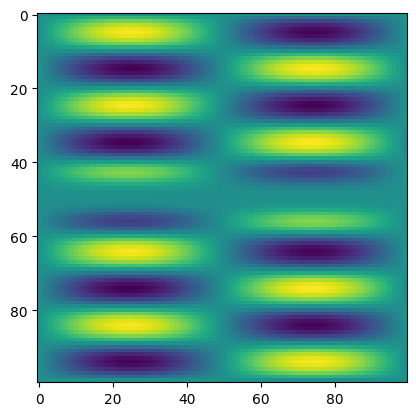

In [24]:
out,_,_ = gme.get_field_xy('E',0,0,0)
plt.imshow(np.real(out['x']))
plt.show()